In [109]:
import string
import pandas as pd
import numpy as np
import nltk
import contractions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import os

import keras.backend as K

from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

In [110]:
mydataset = pd.read_csv("finalDatasetSimplifiedNumerical.csv")
df = pd.DataFrame(data=mydataset)

In [111]:
## Shuffle dataset to reducing variance and making sure that models remains
## general and overfits less.

df = shuffle(df)

In [112]:
def preprocess_text(text, flg_contracts=True, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean - convert to lowercase and remove punctuations and
    ## special characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Convert from string to list
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    ## Open contractions
    if flg_contracts == True:
        lst_text = [contractions.fix(word) for word in lst_text]

    ## Stemming (remove word stems e.g. -ing, -ly)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df["text"].apply(lambda x:
          preprocess_text(x, flg_contracts=True, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

In [113]:
df.head()

,text,sentiment,text_clean
4194,In: Dutton WH Peltu M ed. Society on the line:...,1,dutton wh peltu ed society line information co...
1247,The research portfolio includes studies with p...,0,research portfolio includes study patient heal...
6382,In: 57th ASH Annual Meeting 2015. 2015 Orlando...,1,57th ash annual meeting 2015 2015 orlando usa ...
8984,IMA Journal of Mathematical Control and Inform...,1,i am about to journal mathematical control inf...
7945,Here's a paper on some of our work - it shows ...,0,here is paper work show approach dramatically ...


In [114]:
## Check for null values
df.isnull().sum()

text          0
sentiment     0
text_clean    0
dtype: int64

In [115]:
count = df['sentiment'].value_counts()
print(count)

1    7610
0    2437
Name: sentiment, dtype: int64


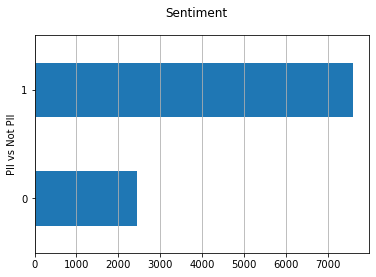

In [116]:
fig, ax = plt.subplots()
fig.suptitle("Sentiment", fontsize=12)
df["sentiment"].reset_index().groupby("sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.ylabel('PII vs Not PII')
plt.show()

In [117]:
## Split dataset into training and test set
train_size = int(df.shape[0] * 0.7)

train_df = df[:train_size]
val_df = df[train_size:]

## split text and labels
train_sentences = train_df.text_clean.to_numpy()
train_labels = train_df.sentiment.to_numpy()
val_sentences = val_df.text_clean.to_numpy()
val_labels = val_df.sentiment.to_numpy()

In [118]:
train_sentences.shape, val_sentences.shape

((7032,), (3015,))

In [119]:
## Amount of PII in train datasets
yTrain_df = pd.DataFrame(train_labels, columns = ['Sentiment'])
yTrain_df.value_counts()

Sentiment
1            5346
0            1686
dtype: int64

In [120]:
## Amount of PII in test datasets
yVal_df = pd.DataFrame(val_labels, columns = ['Sentiment'])
yVal_df.value_counts()

Sentiment
1            2264
0             751
dtype: int64

In [121]:
## vectorsing using TF-IDF
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_sentences)
test_vectors = vectorizer.transform(val_sentences)

In [122]:
ROS = RandomOverSampler(sampling_strategy=1)

In [123]:
## Oversampling data to increase the minority class
train_vectors_ros, train_labels_ros = ROS.fit_resample(train_vectors, train_labels)

In [124]:
ros_yTrain = pd.DataFrame(train_labels_ros, columns = ['sentiment'])

In [125]:
Counter(train_labels_ros)

Counter({1: 5346, 0: 5346})

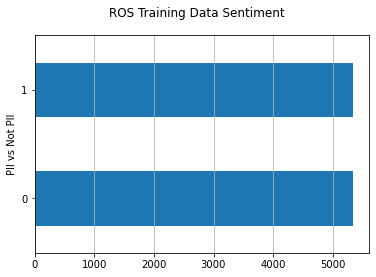

In [126]:
fig, ax = plt.subplots()
fig.suptitle("ROS Training Data Sentiment", fontsize=12)
ros_yTrain["sentiment"].reset_index().groupby("sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.ylabel('PII vs Not PII')
plt.show()

In [127]:
## Multinominal Naive Bayes

## Train model
mlb = MultinomialNB().fit(train_vectors_ros, train_labels_ros)

## Predict training labels
mlb_TrainPred = mlb.predict(train_vectors)
mlb_TrainPred_prob = mlb.predict_proba(train_vectors)

## Predict test labels 
mlb_predicted = mlb.predict(test_vectors)
mlb_predicted_prob = mlb.predict_proba(test_vectors)

In [128]:
print("Multinominal Naive Bayes Training accuracy")
print(accuracy_score(train_labels, mlb_TrainPred))
print()
print("Multinominal Naive Bayes Validation accuracy")
print(accuracy_score(val_labels, mlb_predicted))

Multinominal Naive Bayes Training accuracy
0.925910125142207

Multinominal Naive Bayes Validation accuracy
0.8988391376451078


Multinominal Naive Bayes Accuracy: 0.9
Detail:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       751
           1       0.97      0.90      0.93      2264

    accuracy                           0.90      3015
   macro avg       0.86      0.90      0.87      3015
weighted avg       0.91      0.90      0.90      3015



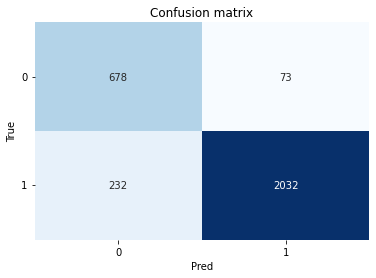

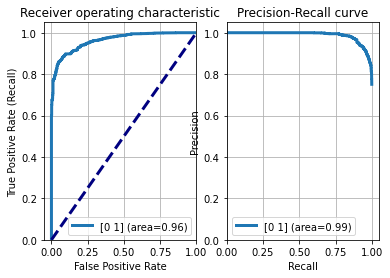

In [129]:
##      Visualisations of evaluation metrics
##      https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
##      Original author - Mauro Di Pietro
##      Modifying author - Caitlin Brown
##      Date modified: 27/07/2022

classes = np.unique(val_labels)
y_test_array = pd.get_dummies(val_labels, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(val_labels, mlb_predicted)
print("Multinominal Naive Bayes Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(val_labels, mlb_predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(val_labels, mlb_predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
fpr, tpr, thresholds = metrics.roc_curve(y_test_array[::,1],  
                        mlb_predicted_prob[::,1])
ax[0].plot(fpr, tpr, lw=3, 
            label='{0} (area={1:0.2f})'.format(classes[:], 
                        metrics.auc(fpr, tpr))
            )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(
                y_test_array[::,1], mlb_predicted_prob[::,1])
ax[1].plot(recall, precision, lw=3, 
            label='{0} (area={1:0.2f})'.format(classes[:], 
                                metrics.auc(recall, precision))
            )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [130]:
## Random Forest classifier 

## Train model
RandomFC = RandomForestClassifier(n_estimators=100)
RandomFC.fit(train_vectors_ros, train_labels_ros)

## Predict training labels 
RdmFC_TrainPred = RandomFC.predict(train_vectors)
RdmFC_TrainPred_prob = RandomFC.predict_proba(train_vectors)

## Predict test labels 
RdmFC_predicted = RandomFC.predict(test_vectors)
RdmFC_predicted_prob = RandomFC.predict_proba(test_vectors)

In [131]:
print("Random Forest Training accuracy")
print(accuracy_score(train_labels, RdmFC_TrainPred))
print()
print("Random Forest Validation accuracy")
print(accuracy_score(val_labels, RdmFC_predicted))

Random Forest Training accuracy
0.999004550625711

Random Forest Validation accuracy
0.9333333333333333


Random Forest Accuracy: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       751
           1       0.97      0.94      0.96      2264

    accuracy                           0.93      3015
   macro avg       0.90      0.92      0.91      3015
weighted avg       0.94      0.93      0.93      3015



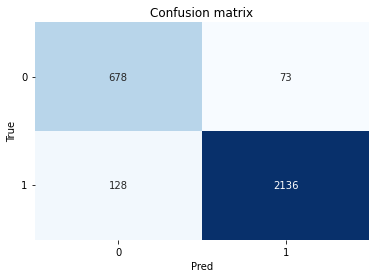

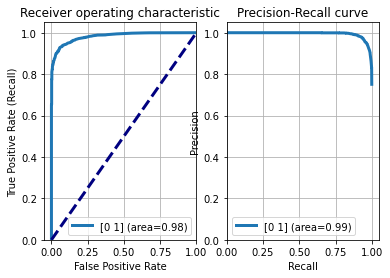

In [132]:
##      Visualisations of evaluation metrics
##      https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
##      Original author - Mauro Di Pietro
##      Modifying author - Caitlin Brown
##      Date modified: 27/07/2022

classes = np.unique(val_labels)
y_test_array = pd.get_dummies(val_labels, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(val_labels, RdmFC_predicted)
print("Random Forest Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(val_labels, RdmFC_predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(val_labels, RdmFC_predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
fpr, tpr, thresholds = metrics.roc_curve(y_test_array[::,1],  
                        RdmFC_predicted_prob[::,1])
ax[0].plot(fpr, tpr, lw=3, 
            label='{0} (area={1:0.2f})'.format(classes[:], 
                            metrics.auc(fpr, tpr))
            )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(
                y_test_array[::,1], RdmFC_predicted_prob[::,1])
ax[1].plot(recall, precision, lw=3, 
            label='{0} (area={1:0.2f})'.format(classes[:], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [133]:
## LSTM

In [134]:
from collections import Counter

## Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df['text_clean'])

In [135]:
len(counter)

28440

In [136]:
counter.most_common(10)

[('j', 2622),
 ('r', 1710),
 ('c', 1530),
 ('p', 1373),
 ('university', 1182),
 ('journal', 1170),
 ('research', 1164),
 ('l', 943),
 ('study', 937),
 ('international', 870)]

In [137]:
num_unique_words = len(counter)

In [138]:
## Count longest sentence

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(df['text_clean'], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [139]:
print(length_long_sentence)

318


In [140]:
from tensorflow.keras.preprocessing.text import Tokenizer

## Vectorize the text by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) 

In [141]:
## Unique index for each word
word_index = tokenizer.word_index

In [142]:
## Convert text to a unique sequence
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [143]:
## Comparison of 5 of the original sentences with their sequences 
print(train_sentences[1500:1510])
print(train_sequences[1500:1510])

['journal epidemiology community health 2007 617 571574 dahlberg l bambra c demack age gender informal carers populationbased study uk'
 'education training'
 'use whole genome data investigate contrasting role vertical horizontal inheritance including gene endosymbiotic origin shaping eukaryotic genome'
 'mres module mmb8016 molecular microbiology'
 'july 1999 paper entitled family policy reconstructing fatherhood law society association annual meeting'
 'emerald publishing limited 2022 laing k todd l using collaborative theory change approach evaluating outofschool learning'
 'group identifying predictor dementia parkinson disease supported programme grant parkinson uk identify people parkinson disease high risk incident dementia iciclepd'
 'sage 2010 pain r panelli r little j kindon moment everydaydistant geopolitics young people fear hope'
 'home u'
 'journal membrane science 2020 600 117855 kousi k neagu bekris l papaioannou ei metcalfe endogenous nanoparticles strain perovskite h

In [144]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Max number of words in a sequence
max_length = 100

## Pad the sequences to have the same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((7032, 100), (3015, 100))

In [145]:
## Print a sample of the data with zeros used as padding 
train_padded[1505]

array([133, 774,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [146]:
## Comparison of the same entry as a sentence, sequence and padded 
print(train_sentences[1501])
print(train_sequences[1501])
print(train_padded[1501])

education training
[133, 774]
[133 774   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [147]:
## Check reversing the indices
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [148]:
# reverse_word_index

In [149]:
## Decode function takes in sequence and returns it's original text value,
## if unavailable returns ? 

def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [150]:
decoded_text = decode(train_sequences[1501])

print(train_sequences[1501])
print(decoded_text)

[133, 774]
education training


In [151]:
## Oversampling data to increase the minority class
train_padded_ros, train_labels_ros = ROS.fit_resample(train_padded, train_labels)

In [152]:
Counter(train_labels_ros)

Counter({1: 5346, 0: 5346})

In [153]:
## Create LSTM model
from tensorflow.keras import layers

## Create sequential model
model = keras.models.Sequential()
## Params: number of unique words, size, maximum length of sequence 
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

## The layer will take as input an integer matrix of size (batch, input_length),
## and the largest integer (i.e. word index) in the input should be no larger than num_words.

## Params: number of output units, dropout = 10%
model.add(layers.LSTM(64, dropout=0.1))

## Dense layer - 1 output at the end, sigmoid function
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           910080    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 934,977
Trainable params: 934,977
Non-trainable params: 0
_________________________________________________________________


In [154]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
## Optimiser 
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

## Configure the model for training
model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [155]:
## Model training 

## Validation data parameter = tuple, automatically uses validation dataset to do fine tuning during training
## Shuffle data after each epoch to help with overfitting
training = model.fit(train_padded_ros, train_labels_ros, epochs=70, validation_data=(val_padded, val_labels), verbose=2, shuffle=True)

Epoch 1/70
335/335 - 13s - loss: 0.6934 - accuracy: 0.5002 - val_loss: 0.6852 - val_accuracy: 0.7509 - 13s/epoch - 39ms/step
Epoch 2/70
335/335 - 10s - loss: 0.6933 - accuracy: 0.4957 - val_loss: 0.6842 - val_accuracy: 0.7509 - 10s/epoch - 31ms/step
Epoch 3/70
335/335 - 10s - loss: 0.6930 - accuracy: 0.5036 - val_loss: 0.7064 - val_accuracy: 0.2517 - 10s/epoch - 31ms/step
Epoch 4/70
335/335 - 10s - loss: 0.6121 - accuracy: 0.6467 - val_loss: 0.6167 - val_accuracy: 0.8312 - 10s/epoch - 31ms/step
Epoch 5/70
335/335 - 11s - loss: 0.5570 - accuracy: 0.7142 - val_loss: 0.5320 - val_accuracy: 0.8345 - 11s/epoch - 33ms/step
Epoch 6/70
335/335 - 11s - loss: 0.5460 - accuracy: 0.7230 - val_loss: 0.5249 - val_accuracy: 0.8352 - 11s/epoch - 32ms/step
Epoch 7/70
335/335 - 11s - loss: 0.5356 - accuracy: 0.7331 - val_loss: 0.5368 - val_accuracy: 0.8401 - 11s/epoch - 32ms/step
Epoch 8/70
335/335 - 11s - loss: 0.5245 - accuracy: 0.7435 - val_loss: 0.4956 - val_accuracy: 0.8478 - 11s/epoch - 33ms/step


335/335 - 10s - loss: 0.0469 - accuracy: 0.9906 - val_loss: 0.3156 - val_accuracy: 0.9290 - 10s/epoch - 30ms/step
Epoch 67/70
335/335 - 10s - loss: 0.0472 - accuracy: 0.9905 - val_loss: 0.3287 - val_accuracy: 0.9280 - 10s/epoch - 30ms/step
Epoch 68/70
335/335 - 10s - loss: 0.0467 - accuracy: 0.9905 - val_loss: 0.3354 - val_accuracy: 0.9284 - 10s/epoch - 30ms/step
Epoch 69/70
335/335 - 10s - loss: 0.0447 - accuracy: 0.9907 - val_loss: 0.3297 - val_accuracy: 0.9260 - 10s/epoch - 30ms/step
Epoch 70/70
335/335 - 10s - loss: 0.0458 - accuracy: 0.9905 - val_loss: 0.3355 - val_accuracy: 0.9290 - 10s/epoch - 31ms/step


In [156]:
## Predictions
## As sigmoid function used has to be converted to a label representing 0 or 1 
predictions = model.predict(train_padded)
## If prediction output probability is higher than 0.5 = 1 if not 0
predictions = [1 if p > 0.5 else 0 for p in predictions]

y_pred = (model.predict(val_padded).ravel()>0.5)+0 
y_predict_prob = model.predict(val_padded)
predict_classes=np.argmax(y_predict_prob,axis=1)

95/95 [==============================] - 1s 9ms/step


In [157]:
## Sample of sentences, their actual labels and predicted labels 
print(train_sentences[1500:1510])

print(train_labels[1500:1510])
print(predictions[1500:1510])

['journal epidemiology community health 2007 617 571574 dahlberg l bambra c demack age gender informal carers populationbased study uk'
 'education training'
 'use whole genome data investigate contrasting role vertical horizontal inheritance including gene endosymbiotic origin shaping eukaryotic genome'
 'mres module mmb8016 molecular microbiology'
 'july 1999 paper entitled family policy reconstructing fatherhood law society association annual meeting'
 'emerald publishing limited 2022 laing k todd l using collaborative theory change approach evaluating outofschool learning'
 'group identifying predictor dementia parkinson disease supported programme grant parkinson uk identify people parkinson disease high risk incident dementia iciclepd'
 'sage 2010 pain r panelli r little j kindon moment everydaydistant geopolitics young people fear hope'
 'home u'
 'journal membrane science 2020 600 117855 kousi k neagu bekris l papaioannou ei metcalfe endogenous nanoparticles strain perovskite h

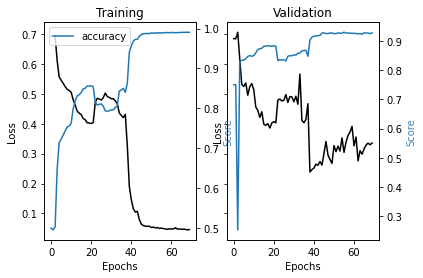

In [158]:
##      Visualisation of LSTM epochs in training and test data
##      https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
##      Original author - Mauro Di Pietro
##      Modifying author - Caitlin Brown
##      Date modified: 27/07/2022

## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(train_labels))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in train_labels])


## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Accuracy: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       751
           1       0.96      0.95      0.95      2264

    accuracy                           0.93      3015
   macro avg       0.90      0.91      0.91      3015
weighted avg       0.93      0.93      0.93      3015



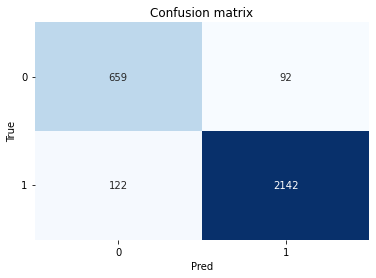

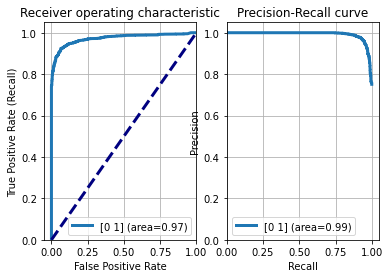

In [159]:
##      Visualisations of evaluation metrics
##      https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
##      Original author - Mauro Di Pietro
##      Modifying author - Caitlin Brown
##      Date modified: 27/07/2022

from  sklearn.metrics  import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics  import roc_curve
from  sklearn.metrics  import auc
from  sklearn.metrics  import precision_recall_curve

classes = np.unique(val_labels)
y_test_array = pd.get_dummies(val_labels, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = accuracy_score(val_labels, y_pred)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(classification_report(val_labels, y_pred))
    
## Plot confusion matrix
cm = confusion_matrix(val_labels, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
# for i in range(len(classes)):
fpr, tpr, thresholds = roc_curve(y_test_array[::,1],  
                        y_predict_prob[:])
ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[:], 
                            auc(fpr, tpr))
            )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
# for i in range(len(classes)):
precision, recall, thresholds = precision_recall_curve(
            y_test_array[::,1], y_predict_prob[:])
ax[1].plot(recall, precision, lw=3, 
            label='{0} (area={1:0.2f})'.format(classes[:], 
                                auc(recall, precision))
            )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()